In [ ]:
%load_ext autoreload
%autoreload 2

# Test and use the library

In [ ]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from transformers import pipeline
from sentence_transformers import (
    SentenceTransformer,
    util,
)
import spacy

from cached_pipe import PipelineCache
from epub import (
    EPub,
    Chapter,
)
from utils import (
    get_ebook_folder,
)


### Load NLP objects

In [ ]:
lts = ["en", "fr"]
lts_pair = list(zip(lts, lts[::-1]))
lts, lts_pair


In [ ]:
nlp = {
    "en": spacy.load("en_core_web_md"),
    "fr": spacy.load("fr_core_news_md"),
}


In [ ]:
# TODO:
# Should export env variables to avoid needing an internet connection.
# https://huggingface.co/docs/transformers/installation#offline-mode


In [ ]:
pipe = {
    f"{lt}_{lt_other}": pipeline("translation", model=f"Helsinki-NLP/opus-mt-{lt}-{lt_other}")
    for lt, lt_other in lts_pair
}


## Load cached translator pipeline

In [ ]:
cache_file_path = {
    f"{lt}_{lt_other}": Path(f"translated_{lt}_{lt_other}.json")
    for lt, lt_other in lts_pair
}


In [ ]:
pipe_cache = {
    (lt_pair := f"{lt}_{lt_other}"): PipelineCache(
        pipe[lt_pair], cache_file_path[lt_pair], lt, lt_other
    )
    for lt, lt_other in lts_pair
}


In [ ]:
pipe_cache["en_fr"]("Let's try this cool way to create a callable class.")


## Load epubs

In [ ]:
ebook_folder = get_ebook_folder()
epub_path = {
    "fr": ebook_folder / "Gaston_Leroux_-_Le_Mystere_de_la_chambre_jaune.epub",
    "en": ebook_folder / "mystery_yellow_room.epub",
}
print(epub_path)


In [ ]:
epub = {
    lt: EPub(epub_path[lt], nlp, pipe_cache, lt, lt_other)
    for lt, lt_other in zip(lts, lts[::-1])
}


### Translate a manazza and check for similarity with spacy

In [ ]:
sent_fr = epub["fr"].chapters[1].paragraphs[0].sents_orig[0]
sent_fr.text


In [ ]:
sent_fr_to_en = pipe["fr_en"](sent_fr.text)
sent_fr_to_en


In [ ]:
doc_fr_to_en = nlp["en"](sent_fr_to_en[0]["translation_text"])
print(type(doc_fr_to_en))
doc_fr_to_en


In [ ]:
sent_en = epub["en"].chapters[0].paragraphs[2].sents_orig[0]
print(type(sent_en))
sent_en


In [ ]:
doc_fr_to_en.similarity(sent_en)


In [ ]:
sent_en2 = epub["en"].chapters[0].paragraphs[2].sents_orig[2]
print(sent_en2)

doc_fr_to_en.similarity(sent_en2)


### Iterate over sentences

In [ ]:
def iter_sent(chap: Chapter, start_chap: int = 0, end_chap: int = 0, which_sent="orig"):
    """"""
    if end_chap == 0:
        end_chap = len(chap.paragraphs) + 1
    for i_p, par in enumerate(chap.paragraphs[start_chap:end_chap]):
        for i_s, sent in enumerate(par.sents_orig):
            if which_sent == "orig":
                yield (i_p + start_chap, i_s), sent
            elif which_sent == "tran":
                yield (i_p + start_chap, i_s), par.sents_tran[i_s]


In [ ]:
sent_text_en = []
for k, sent in iter_sent(epub["en"].chapters[0], which_sent="orig"):
    text_en = sent.text
    # print(k, text_en)
    sent_text_en.append(text_en)

sent_text_fr_tran = []
for k, sent in iter_sent(epub["fr"].chapters[1], which_sent="tran"):
    text_fr_tran = sent.text
    sent_text_fr_tran.append(text_fr_tran)

print(sent_text_en[4])
print(sent_text_fr_tran[2])


## Sentence encoder used for similarity

In [ ]:
# model = SentenceTransformer("paraphrase-MiniLM-L6-v2")
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# Our sentences we like to encode
sentences = [
    "This framework generates embeddings for each input sentence",
    "Sentences are passed as a list of string.",
    "The quick brown fox jumps over the lazy dog.",
]

# Sentences are encoded by calling model.encode()
embeddings = model.encode(sentences)

# # Print the embeddings
# for sentence, embedding in zip(sentences, embeddings):
#     print("Sentence:", sentence)
#     print("Embedding:", embedding)
#     print("")


In [ ]:
sentences = ["I'm happy", "I'm full of happiness"]


# Compute embedding for both lists
embedding_1 = model.encode(sentences[0], convert_to_tensor=True)
embedding_2 = model.encode(sentences[1], convert_to_tensor=True)

util.pytorch_cos_sim(embedding_1, embedding_2)


In [ ]:
embedding_1 = model.encode(sent_en.text, convert_to_tensor=True)
embedding_2 = model.encode(sent_en2.text, convert_to_tensor=True)
embedding_fr = model.encode(doc_fr_to_en.text, convert_to_tensor=True)
fr1 = util.pytorch_cos_sim(embedding_1, embedding_fr)
fr2 = util.pytorch_cos_sim(embedding_2, embedding_fr)
fr1, fr2


### Convert sents to embedding and compute the distance

In [ ]:
sent_num_en = len(sent_text_en)
enc_en = model.encode(sent_text_en, convert_to_tensor=True)
print('en',enc_en.shape, sent_num_en, enc_en[0].shape)

sent_num_fr = len(sent_text_fr_tran)
enc_fr_tran = model.encode(sent_text_fr_tran, convert_to_tensor=True)
print('fr',enc_fr_tran.shape, sent_num_fr, enc_fr_tran[0].shape)

In [ ]:
# sim = np.zeros((sent_num_en, sent_num_fr))
# for i in range(sent_num_en):
#     for ii in range(sent_num_fr):
#         sim[i][ii] = util.pytorch_cos_sim(enc_en[i], enc_fr_tran[ii])
#         # sim[i][ii] = util.pytorch_cos_sim(enc_en[i], enc_en[ii])
# plt.imshow(sim)


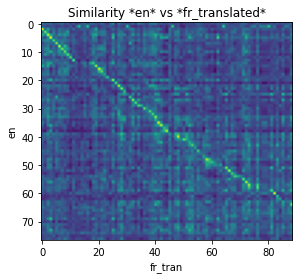

In [29]:
sim = util.pytorch_cos_sim(enc_en, enc_fr_tran)
plt.imshow(sim.detach().cpu().numpy())
plt.title(f"Similarity *en* vs *fr_translated*")
plt.ylabel("en")
plt.xlabel("fr_tran")
plt.show()
